## IMPORTS 

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from collections import Counter

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

### Basic Parameters

In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
data = pd.read_csv("data/data_all.csv")

In [4]:
data.head()

,text,target,emotion
0,us need band together apart nevertrump promote...,0,anger
1,bain life drive cash point shop change pound c...,0,anger
2,clearly appreciate sub-harmonics -one,1,joy
3,honestly know i'm unhappy time want stop itnev...,3,sadness
4,sleep cooties ni close eyes dream i'm awake we...,3,sadness


In [5]:
data.shape

(5051, 3)

In [6]:
data.isna().sum()

text       0
target     0
emotion    0
dtype: int64

## Finding the maxlen

In [7]:
data["len"] = 

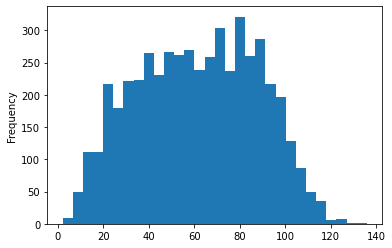

In [8]:
data["len"].
plt.show()

In [9]:
data.len.quantile(0.9)

96.0

## Preprocessing Y Column
We are only going to be classifying conditions for which the count of reviews are more than 3000.

In [10]:
# count_df = data[["text","emotion"]].groupby("emotion").aggregate({"text":"count"}).reset_index().sort_values("text",ascending=False)
count_df = pd.DataFrame.from_dict(Counter(data["emotion"]), orient="index", columns=["count"])
count_df

,count
anger,2118
joy,1163
sadness,1325
optimism,445


In [11]:
target_conditions = count_df.index.values
target_conditions

array(['anger', 'joy', 'sadness', 'optimism'], dtype=object)

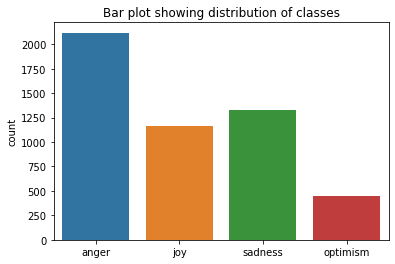

In [12]:
sns.barplot(data=count_df, x=count_df.index, y="count")
plt.title("Bar plot showing distribution of classes")
plt.show()

## Cleaning text

In [13]:
import re
import nltk
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

In [14]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [15]:
# Clean the text
data["text"] = data["text"].apply(lambda x: clean_text(x))

# Clean numbers
data["text"] = data["text"].apply(lambda x: clean_numbers(x))

# lower and stopwords removal
data["text"] = data["text"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))

# lower the text
data["text"] = data["text"].apply(lambda x: x.lower())

data.head()

,text,target,emotion,len
0,us need band together apart nevertrump promote...,0,anger,65
1,bain life drive cash point shop change pound c...,0,anger,74
2,clearly appreciate sub-harmonics -one,1,joy,37
3,honestly know i'm unhappy time want stop itnev...,3,sadness,52
4,sleep cooties ni close eyes dream i'm awake we...,3,sadness,72


In [16]:
data["emotion"].unique()

array(['anger', 'joy', 'sadness', 'optimism'], dtype=object)

In [17]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data["text"], data["emotion"],
                                                    stratify=data["emotion"], 
                                                    test_size=0.25)

In [18]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3788,)
Test shape :  (1263,)


In [19]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [21]:
le.classes_

array(['anger', 'joy', 'optimism', 'sadness'], dtype=object)

### Load Embeddings


In [26]:
def load_glove_vectors(glove_file="glove/glove.42B.300d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            #print(line)
            split = line.split()
            #print(split[0])
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [27]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [28]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [29]:
vocab

array(['', 'UNK'], dtype='<U3')

In [34]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove/glove.42B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [35]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/home/gundruke/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: all input arrays must have the same shape

In [28]:
embedding_matrix = load_glove(tokenizer.word_index)

ValueError: all input arrays must have the same shape

In [24]:
np.shape(embedding_matrix)

NameError: name 'embedding_matrix' is not defined

## Pytorch Model - TextCNN

In [32]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [33]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

NameError: name 'embedding_matrix' is not defined

In [ ]:
torch.save(model,'textcnn_model')

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [ ]:
plot_graph(n_epochs)

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

plt.show()

## Pytorch Model - BiLSTM

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

In [ ]:
plot_graph(n_epochs)

In [ ]:
torch.save(model,'bilstm_model')

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)
plt.show()

## Deploy : Predict A Single Example

In [ ]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [ ]:
x = data['review'].values[20]
print(x)

In [ ]:
predict_single(x)